# Investigation of CFD output manipulation in Python

## First, open up a sample CFD output file

In [1]:
import vtk
from vtk import vtkXMLUnstructuredGridReader
fname = "c:/Users/rd73/Documents/Work/SWEPT2/samples/CFD/n0012_897_a0p0_P12_OUTPUT/n0012_897_a0p0_0_0.vtu"
reader = vtkXMLUnstructuredGridReader()
reader.SetFileName(fname)
reader.Update()

In [2]:
a = reader.GetOutput()
reader.GetOutput().GetCellData().SetActiveScalars('V')
b = reader.GetOutput().GetCellData()

In [3]:
import vtk.util.numpy_support as VN
d = VN.vtk_to_numpy( b.GetArray('V') )

In [33]:
import numpy
img = []
for i in d:
    rms = numpy.sqrt(i[0]**2+i[1]**2+i[2]**2)
    img.append(rms)
img = img + [0] * 120
numpy_img = numpy.zeros((501,39))

In [37]:
numpy_img = numpy.copy( img )
numpy_reorg = numpy.reshape( numpy_img, [39,501])

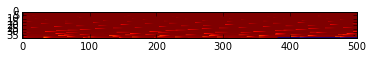

In [38]:
%matplotlib inline
import matplotlib.pyplot as mpl
mpl.imshow(numpy_reorg);

In [18]:
reslice = vtk.vtkImageReslice()

In [19]:
reslice.SetResliceAxesDirectionCosines(1,0,0,0,1,0,0,0,1)
reslice.SetOutputDimensionality(2)
reslice.SetResliceAxesOrigin(0,0,0)

In [20]:
reslice.SetInputConnection( reader.GetOutputPort() )
reslice.Update()

In [21]:
a = reslice.GetOutput()

In [38]:
a.GetScalarTypeAsString()

'double'

In [23]:
writer = vtk.vtkPNGWriter()
writer.SetWriteToMemory(1)

In [24]:
writer.SetInputConnection(reslice.GetOutputPort())
writer.Write()

In [26]:
data = str(buffer(writer.GetResult()))
from IPython.display import Image
Image(data)

TypeError: buffer object expected

## Create an actor to utilise the data produced by the cut

In [4]:
plane = vtk.vtkPlane()
plane.SetOrigin(reader.GetOutput().GetCenter())
plane.SetNormal(0,1,0)
planeCut = vtk.vtkCutter()
planeCut.SetInputConnection(reader.GetOutputPort())
planeCut.SetCutFunction(plane)
planeCut.Update()
cutterMapper=vtk.vtkPolyDatpaMapper()
cutterMapper.SetInputConnection( planeCut.GetOutputPort())

AttributeError: 'module' object has no attribute 'vtkPolyDatpaMapper'

In [ ]:
planeActor=vtk.vtkActor()
planeActor.GetProperty().SetColor(1.0,1,0)
planeActor.GetProperty().SetLineWidth(2)
planeActor.SetMapper(cutterMapper)

## And now render to an image
Here we choose to set the camera at a more distant offset and angle to show detail in the static image generated below. The preference is to extract the cut plane information directly into some kind of 2-d matrix which can then be more readily compared with the planar data obtained from the LIDAR systems.

In [ ]:
#create renderers and add actors of plane and cube
ren = vtk.vtkRenderer()
camera = vtk.vtkCamera()
camera.SetPosition(200,800,200)
#camera.SetFocalPoint(0,0,0)
camera.SetFocalPoint( reader.GetOutput().GetCenter())
ren.SetActiveCamera( camera )
ren.AddActor(planeActor)
#Add renderer to renderwindow and render
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren)
renWin.SetSize(600, 600)
ren.SetBackground(0,0,0)

##Here we can create an interactive render window

In [5]:
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renWin)
renderWindowInteractor.Initialize()
renWin.Render()
renderWindowInteractor.Start()

NameError: name 'renWin' is not defined

##Or process the data into an image

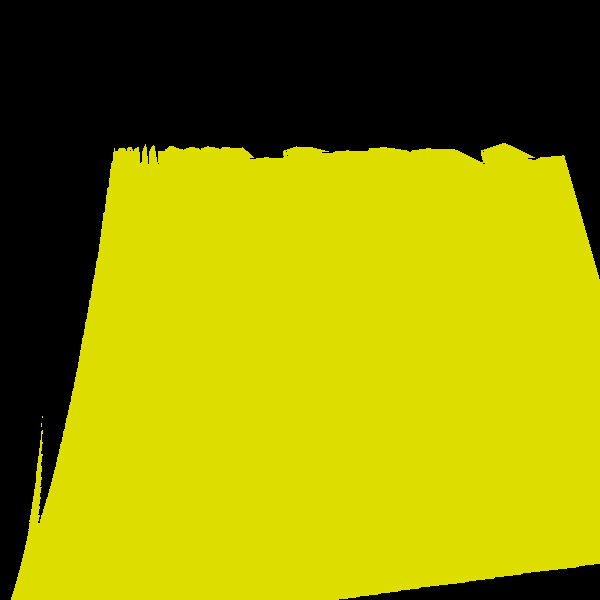

In [5]:
renWin.SetOffScreenRendering(1)
renWin.Render()
windowToImageFilter = vtk.vtkWindowToImageFilter()
windowToImageFilter.SetInput( renWin )

writer = vtk.vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = str(buffer(writer.GetResult()))
from IPython.display import Image
Image(data)

The odd jagged edge of the cut plane appears to be due to visual clipping in the render window and is not a feature of the extracted data.

Can we image the plane directly?

In [13]:
reslice.GetOutput()

(vtkImageData)0000000004AEBE60